In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, ConcatDataset, random_split
import matplotlib.pyplot as plt
import numpy
import numpy as np
from tqdm import tqdm

device = 'cuda:2'

In [2]:
def show_tensor_images(image_tensor, num_images=20, size=(3, 32, 32)):
    
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [3]:
transformations = transforms.Compose([
    transforms.RandomVerticalFlip(p=1),
    transforms.ToTensor()
])

In [4]:
trainset1 = datasets.CIFAR10(root='/home/aminul/data1', train = True, download =False, transform = transformations)
trainset2 = datasets.CIFAR10(root='/home/aminul/data1', train = True, download =False, transform = transforms.ToTensor())
num_classes = 2

for i in range(len(trainset1.targets)):
    trainset1.targets[i] = 1
    
for i in range(len(trainset2.targets)):
    trainset2.targets[i] = 0   

    
new_dataset = ConcatDataset([trainset1,trainset2])
trainset,testset = random_split(new_dataset, [round(len(new_dataset)*.8), round(len(new_dataset)*.2)])

In [5]:
train_loader = DataLoader(trainset, 128, shuffle = True, num_workers = 2)
test_loader = DataLoader(testset, 128, shuffle = True, num_workers = 2)

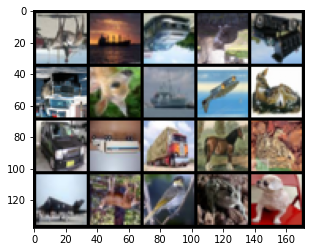

In [6]:
d = iter(train_loader)
x,y = next(d)

show_tensor_images(x)

In [7]:
for i in range(20):
    print(i, "Origianl Labels:", y[i])

0 Origianl Labels: tensor(1)
1 Origianl Labels: tensor(0)
2 Origianl Labels: tensor(1)
3 Origianl Labels: tensor(1)
4 Origianl Labels: tensor(1)
5 Origianl Labels: tensor(1)
6 Origianl Labels: tensor(1)
7 Origianl Labels: tensor(0)
8 Origianl Labels: tensor(1)
9 Origianl Labels: tensor(0)
10 Origianl Labels: tensor(0)
11 Origianl Labels: tensor(1)
12 Origianl Labels: tensor(0)
13 Origianl Labels: tensor(0)
14 Origianl Labels: tensor(1)
15 Origianl Labels: tensor(0)
16 Origianl Labels: tensor(1)
17 Origianl Labels: tensor(0)
18 Origianl Labels: tensor(0)
19 Origianl Labels: tensor(0)


In [8]:
class Net(nn.Module):
    def __init__(self, input_channel, num_class):
        super(Net,self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=input_channel,out_channels=8,kernel_size=3,stride=1)
        self.dropout1 = nn.Dropout(0.3)
        self.conv2 = nn.Conv2d(in_channels=8,out_channels=16,kernel_size=3,stride=1)
        self.dropout2 = nn.Dropout(0.3)
        self.fc1 = nn.Linear(64, 256)
        self.dropout5 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256,128)
        self.dropout6 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(128, num_class)
        
    def forward(self, x):
        
        x = F.max_pool2d(F.relu(self.conv1(x)),kernel_size=3)
        x = self.dropout1(x)
        x = F.max_pool2d(F.relu(self.conv2(x)),kernel_size=3)
        x = self.dropout2(x)
        x = F.relu(self.fc1(x.reshape(-1,x.shape[1] * x.shape[2]*x.shape[3])))
        x = self.dropout5(x)
        x = F.relu(self.fc2(x))
        x = self.dropout6(x)
        x = self.fc3(x)
        
        return x 

In [9]:
net = Net(3,2).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001,momentum=0.9, weight_decay=5e-4)

In [10]:
def train(net,trainloader,optim,criterion,epoch,device):
    net.train()
    train_loss,total,total_correct = 0,0,0
    
    for i,(inputs,targets) in enumerate(tqdm(trainloader)):
        
        inputs,targets = inputs.to(device), targets.to(device)
        optim.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs,targets)
        loss.backward()
        optim.step()
        
        train_loss += loss.item()
        _,predicted = torch.max(outputs.data,1)
        total_correct += (predicted == targets).sum().item()
        total += targets.size(0)
    
    print("Epoch: [{}]  loss: [{:.2f}] Accuracy [{:.2f}] ".format(epoch+1,train_loss/(i+1),
                                                                           (total_correct*100/total)))
    return train_loss/(i+1),(total_correct*100)/total

In [11]:
def tester(net,testloader,optim,criterion,epoch,device):
    net.eval()
    test_loss,total,total_correct = 0,0,0
    y_pred, y_true = [],[]
    
    for i,(inputs, targets) in enumerate(tqdm(testloader)):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = net(inputs)
        loss = criterion(outputs, targets)

        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        total_correct += (predicted == targets).sum().item()

    y_pred.append(predicted)
    y_true.append(targets)
    acc = 100. * total_correct / total
    print("\nValidation Epoch #%d\t\t\tLoss: %.4f Acc@1: %.2f%%" %(epoch+1, test_loss/(i+1), acc))
        
    return test_loss/(i+1), acc, y_pred, y_true

In [12]:
num_epochs = 100
train_loss,test_loss = [],[]

for epoch in range(num_epochs):
    
    a,b = train(net,train_loader,optimizer,criterion,epoch,device)
    c,d,e,f = tester(net,test_loader,optimizer,criterion,epoch,device)    
    
    train_loss.append(a), test_loss.append(c)

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [1]  loss: [0.69] Accuracy [50.53] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #1			Loss: 0.6925 Acc@1: 57.34%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [2]  loss: [0.69] Accuracy [51.98] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #2			Loss: 0.6918 Acc@1: 55.17%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [3]  loss: [0.69] Accuracy [52.72] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #3			Loss: 0.6905 Acc@1: 57.23%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [4]  loss: [0.69] Accuracy [53.73] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #4			Loss: 0.6886 Acc@1: 57.12%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [5]  loss: [0.69] Accuracy [54.64] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #5			Loss: 0.6852 Acc@1: 58.45%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [6]  loss: [0.68] Accuracy [55.65] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #6			Loss: 0.6802 Acc@1: 59.85%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [7]  loss: [0.68] Accuracy [56.28] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #7			Loss: 0.6770 Acc@1: 59.90%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [8]  loss: [0.68] Accuracy [57.09] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #8			Loss: 0.6729 Acc@1: 60.71%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [9]  loss: [0.67] Accuracy [58.60] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #9			Loss: 0.6664 Acc@1: 62.05%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [10]  loss: [0.66] Accuracy [60.03] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #10			Loss: 0.6549 Acc@1: 63.17%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [11]  loss: [0.65] Accuracy [61.39] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #11			Loss: 0.6438 Acc@1: 63.80%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [12]  loss: [0.64] Accuracy [62.00] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #12			Loss: 0.6323 Acc@1: 64.14%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [13]  loss: [0.64] Accuracy [62.61] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #13			Loss: 0.6274 Acc@1: 64.51%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [14]  loss: [0.63] Accuracy [62.85] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #14			Loss: 0.6224 Acc@1: 64.75%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [15]  loss: [0.63] Accuracy [62.95] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #15			Loss: 0.6227 Acc@1: 64.84%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [16]  loss: [0.63] Accuracy [63.08] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #16			Loss: 0.6175 Acc@1: 64.97%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [17]  loss: [0.63] Accuracy [63.16] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #17			Loss: 0.6152 Acc@1: 65.11%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [18]  loss: [0.63] Accuracy [63.40] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #18			Loss: 0.6147 Acc@1: 65.19%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [19]  loss: [0.62] Accuracy [63.65] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #19			Loss: 0.6142 Acc@1: 65.33%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [20]  loss: [0.62] Accuracy [63.54] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #20			Loss: 0.6148 Acc@1: 65.33%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [21]  loss: [0.62] Accuracy [63.83] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #21			Loss: 0.6135 Acc@1: 65.31%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [22]  loss: [0.62] Accuracy [63.99] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #22			Loss: 0.6109 Acc@1: 65.61%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [23]  loss: [0.62] Accuracy [64.34] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #23			Loss: 0.6075 Acc@1: 66.01%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [24]  loss: [0.62] Accuracy [64.22] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #24			Loss: 0.6080 Acc@1: 66.28%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [25]  loss: [0.61] Accuracy [64.51] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #25			Loss: 0.6057 Acc@1: 66.24%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [26]  loss: [0.61] Accuracy [64.42] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #26			Loss: 0.6071 Acc@1: 66.03%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [27]  loss: [0.61] Accuracy [64.94] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #27			Loss: 0.6057 Acc@1: 66.33%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [28]  loss: [0.61] Accuracy [65.12] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #28			Loss: 0.6058 Acc@1: 66.41%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [29]  loss: [0.61] Accuracy [65.10] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #29			Loss: 0.6024 Acc@1: 66.69%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [30]  loss: [0.61] Accuracy [65.24] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #30			Loss: 0.6042 Acc@1: 65.83%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [31]  loss: [0.61] Accuracy [65.48] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #31			Loss: 0.6005 Acc@1: 66.90%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [32]  loss: [0.61] Accuracy [65.54] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #32			Loss: 0.6008 Acc@1: 66.55%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [33]  loss: [0.61] Accuracy [65.50] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #33			Loss: 0.5995 Acc@1: 67.17%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [34]  loss: [0.61] Accuracy [65.63] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #34			Loss: 0.6036 Acc@1: 65.95%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [35]  loss: [0.60] Accuracy [65.75] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #35			Loss: 0.5977 Acc@1: 66.64%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [36]  loss: [0.60] Accuracy [65.77] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #36			Loss: 0.5968 Acc@1: 67.33%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [37]  loss: [0.60] Accuracy [65.99] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #37			Loss: 0.5966 Acc@1: 67.08%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [38]  loss: [0.60] Accuracy [66.12] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #38			Loss: 0.6011 Acc@1: 66.44%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [39]  loss: [0.60] Accuracy [66.13] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #39			Loss: 0.5942 Acc@1: 67.31%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [40]  loss: [0.60] Accuracy [66.22] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #40			Loss: 0.5975 Acc@1: 66.95%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [41]  loss: [0.60] Accuracy [66.24] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #41			Loss: 0.5977 Acc@1: 66.38%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [42]  loss: [0.60] Accuracy [66.39] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #42			Loss: 0.5921 Acc@1: 67.56%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [43]  loss: [0.60] Accuracy [66.37] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #43			Loss: 0.5960 Acc@1: 67.31%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [44]  loss: [0.60] Accuracy [66.49] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #44			Loss: 0.5947 Acc@1: 67.39%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [45]  loss: [0.60] Accuracy [66.45] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #45			Loss: 0.5937 Acc@1: 67.65%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [46]  loss: [0.59] Accuracy [66.75] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #46			Loss: 0.5907 Acc@1: 67.69%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [47]  loss: [0.59] Accuracy [66.58] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #47			Loss: 0.5883 Acc@1: 68.21%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [48]  loss: [0.59] Accuracy [66.85] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #48			Loss: 0.5935 Acc@1: 67.56%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [49]  loss: [0.59] Accuracy [66.73] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #49			Loss: 0.5906 Acc@1: 67.90%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [50]  loss: [0.59] Accuracy [67.09] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #50			Loss: 0.5919 Acc@1: 67.53%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [51]  loss: [0.59] Accuracy [66.97] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #51			Loss: 0.5874 Acc@1: 68.00%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [52]  loss: [0.59] Accuracy [66.86] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #52			Loss: 0.5887 Acc@1: 68.36%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [53]  loss: [0.59] Accuracy [67.04] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #53			Loss: 0.5863 Acc@1: 68.34%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [54]  loss: [0.59] Accuracy [67.25] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #54			Loss: 0.5904 Acc@1: 68.36%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [55]  loss: [0.59] Accuracy [67.19] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #55			Loss: 0.5844 Acc@1: 68.64%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [56]  loss: [0.59] Accuracy [67.25] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #56			Loss: 0.5862 Acc@1: 68.51%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [57]  loss: [0.59] Accuracy [67.18] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #57			Loss: 0.5863 Acc@1: 68.97%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [58]  loss: [0.59] Accuracy [67.42] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #58			Loss: 0.5837 Acc@1: 68.85%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [59]  loss: [0.59] Accuracy [67.56] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #59			Loss: 0.5832 Acc@1: 68.94%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [60]  loss: [0.59] Accuracy [67.44] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #60			Loss: 0.5870 Acc@1: 68.81%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [61]  loss: [0.59] Accuracy [67.59] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #61			Loss: 0.5843 Acc@1: 68.79%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [62]  loss: [0.59] Accuracy [67.23] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #62			Loss: 0.5889 Acc@1: 67.64%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [63]  loss: [0.59] Accuracy [67.59] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #63			Loss: 0.5823 Acc@1: 68.90%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [64]  loss: [0.58] Accuracy [67.78] 


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [65]  loss: [0.58] Accuracy [67.78] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #65			Loss: 0.5835 Acc@1: 68.60%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [66]  loss: [0.58] Accuracy [67.88] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #66			Loss: 0.5803 Acc@1: 68.66%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [67]  loss: [0.58] Accuracy [67.53] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #67			Loss: 0.5799 Acc@1: 69.24%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [68]  loss: [0.58] Accuracy [67.78] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #68			Loss: 0.5792 Acc@1: 69.17%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [69]  loss: [0.58] Accuracy [67.98] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #69			Loss: 0.5847 Acc@1: 68.22%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [70]  loss: [0.58] Accuracy [68.16] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #70			Loss: 0.5809 Acc@1: 68.90%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [71]  loss: [0.58] Accuracy [67.73] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #71			Loss: 0.5850 Acc@1: 68.90%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [72]  loss: [0.58] Accuracy [67.94] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #72			Loss: 0.5779 Acc@1: 69.06%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [73]  loss: [0.58] Accuracy [67.91] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #73			Loss: 0.5712 Acc@1: 69.80%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [74]  loss: [0.58] Accuracy [68.39] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #74			Loss: 0.5771 Acc@1: 69.35%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [75]  loss: [0.58] Accuracy [68.19] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #75			Loss: 0.5784 Acc@1: 69.06%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [76]  loss: [0.58] Accuracy [68.32] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #76			Loss: 0.5757 Acc@1: 69.27%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [77]  loss: [0.58] Accuracy [68.42] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #77			Loss: 0.5797 Acc@1: 68.68%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [78]  loss: [0.58] Accuracy [68.18] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #78			Loss: 0.5712 Acc@1: 69.86%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [79]  loss: [0.58] Accuracy [68.21] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #79			Loss: 0.5762 Acc@1: 69.06%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [80]  loss: [0.58] Accuracy [68.31] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #80			Loss: 0.5748 Acc@1: 69.31%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [81]  loss: [0.58] Accuracy [68.16] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #81			Loss: 0.5736 Acc@1: 69.16%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [82]  loss: [0.58] Accuracy [68.43] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #82			Loss: 0.5669 Acc@1: 69.83%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [83]  loss: [0.57] Accuracy [68.53] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #83			Loss: 0.5791 Acc@1: 68.90%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [84]  loss: [0.57] Accuracy [68.71] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #84			Loss: 0.5724 Acc@1: 69.78%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [85]  loss: [0.57] Accuracy [68.44] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #85			Loss: 0.5686 Acc@1: 69.73%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [86]  loss: [0.58] Accuracy [68.47] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #86			Loss: 0.5684 Acc@1: 69.91%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [87]  loss: [0.57] Accuracy [68.54] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #87			Loss: 0.5606 Acc@1: 70.54%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [88]  loss: [0.57] Accuracy [68.64] 


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [89]  loss: [0.57] Accuracy [68.68] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #89			Loss: 0.5687 Acc@1: 70.08%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [90]  loss: [0.57] Accuracy [68.44] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #90			Loss: 0.5663 Acc@1: 70.39%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [91]  loss: [0.57] Accuracy [68.48] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #91			Loss: 0.5716 Acc@1: 69.67%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [92]  loss: [0.57] Accuracy [68.44] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #92			Loss: 0.5667 Acc@1: 70.16%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [93]  loss: [0.57] Accuracy [68.96] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #93			Loss: 0.5640 Acc@1: 70.11%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [94]  loss: [0.57] Accuracy [68.77] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #94			Loss: 0.5675 Acc@1: 69.92%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [95]  loss: [0.57] Accuracy [69.06] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #95			Loss: 0.5659 Acc@1: 69.75%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [96]  loss: [0.57] Accuracy [69.18] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #96			Loss: 0.5651 Acc@1: 70.13%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [97]  loss: [0.57] Accuracy [68.96] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #97			Loss: 0.5610 Acc@1: 70.39%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [98]  loss: [0.57] Accuracy [68.80] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #98			Loss: 0.5660 Acc@1: 70.33%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [99]  loss: [0.57] Accuracy [68.75] 


  0%|          | 0/625 [00:00<?, ?it/s]


Validation Epoch #99			Loss: 0.5638 Acc@1: 69.99%


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [100]  loss: [0.57] Accuracy [68.95] 


100%|██████████| 157/157 [00:02<00:00, 62.48it/s]


Validation Epoch #100			Loss: 0.5637 Acc@1: 70.51%


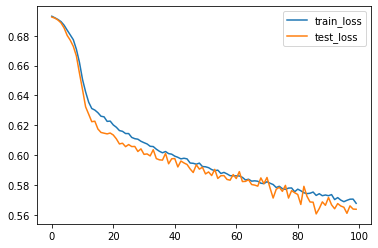

In [17]:
labels = ["train_loss", "test_loss"]
plt.plot(np.array(train_loss))
plt.plot(np.array(test_loss))
plt.legend(labels)
plt.show()

In [14]:
d = iter(test_loader)
x,y = next(d)
x,y = x.to(device),y.to(device)

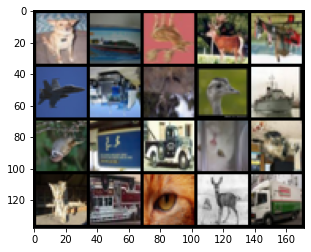

In [15]:
y_pred = net(x)
show_tensor_images(x)

In [16]:
_, predicted = torch.max(y_pred.data, 1)
for i in range(20):
    print(i, "predicted: ", predicted[i].cpu(), "Actual: ", y[i].cpu())

0 predicted:  tensor(0) Actual:  tensor(0)
1 predicted:  tensor(0) Actual:  tensor(0)
2 predicted:  tensor(0) Actual:  tensor(1)
3 predicted:  tensor(1) Actual:  tensor(0)
4 predicted:  tensor(1) Actual:  tensor(1)
5 predicted:  tensor(0) Actual:  tensor(0)
6 predicted:  tensor(1) Actual:  tensor(1)
7 predicted:  tensor(0) Actual:  tensor(1)
8 predicted:  tensor(0) Actual:  tensor(0)
9 predicted:  tensor(0) Actual:  tensor(0)
10 predicted:  tensor(0) Actual:  tensor(1)
11 predicted:  tensor(1) Actual:  tensor(1)
12 predicted:  tensor(0) Actual:  tensor(0)
13 predicted:  tensor(0) Actual:  tensor(1)
14 predicted:  tensor(1) Actual:  tensor(1)
15 predicted:  tensor(0) Actual:  tensor(0)
16 predicted:  tensor(1) Actual:  tensor(1)
17 predicted:  tensor(1) Actual:  tensor(0)
18 predicted:  tensor(0) Actual:  tensor(0)
19 predicted:  tensor(0) Actual:  tensor(0)
